In [1]:
import numpy as np
from numpy import linalg as LA
import math
import sys
from scipy.stats import multivariate_normal
import numpy
import matplotlib.pyplot as plt


In [2]:
def plotX(X,ps=8):
    for i in range(len(X)):
        plt.scatter(X[i][:,0],X[i][:,1],s=ps)
    plt.show()

In [3]:
def nearPSD(A,epsilon=0):
    n = A.shape[0]
    eigval, eigvec = np.linalg.eig(A)
    val = np.matrix(np.maximum(eigval,epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec,vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    out = B*B.T
    return(out)

In [4]:
def gen_dataset(k,d,n):
        dataset = numpy.empty([1,d])
        meancov = []
        X = []
        s    = numpy.random.multinomial(n, [1/k]*k, size=1).flatten()
        l = numpy.empty(s.shape)
        for i in range(k):
            l[i] = s[i]/n  
        z    = numpy.random.multinomial(n, l, size=1).flatten()
        for i in range(k):
            m    = numpy.random.uniform(0,5*k,d)
            mean = numpy.random.multivariate_normal(m+i,i*numpy.identity(d),1).flatten()
            cov  = numpy.identity(d)
            x    = numpy.random.multivariate_normal(mean,cov,z[i])
            X.append(x)
            if(i==0):
                dataset = numpy.vstack((x,dataset))[:-1]
            else:
                dataset = numpy.vstack((dataset,x))
            meancov.append((mean,cov,z))
        return (X,dataset,meancov)

In [70]:
def emalgo(k,d,n,dataset,eps=0.000000000000000001,conveps = 0.000000000000000000000001,epsnoise=0.01,iteration=1,noise_add=0):
    import numpy as np
    from math import log
    from scipy.stats import multivariate_normal

##Initialization 
    dataset = np.array(dataset)
    mu = (sum(dataset))/n
    cov  = [numpy.cov(dataset.T) for _ in range(k)]
    mean = numpy.random.multivariate_normal(mu,cov[0],k)
    pi   = numpy.random.dirichlet(np.ones(k))
    gamma = np.zeros((k,n))
   
    loglikeli = -float('inf')
    xloglikeli = 0
    diff = conveps + 1
    ##
    try:
        while diff >= conveps: ## main loop
            for i in range(k):
                for j in range(n):
                    gamma[i][j] = pi[i] * multivariate_normal.pdf(dataset[j],mean[i],cov[i])


            temp = [0]*n

            gammaT = gamma.T
            for i in range(n):
                temp[i] = sum(gammaT[i])

            for i in range(k):
                for j in range(n):
                    gamma[i][j] = gamma[i][j]/temp[j]

            temp1 = [0]*k
            for i in range(k):
                temp1[i] = sum(gamma[i])

            for i in range(k):
                summat = 0
                for j in range(n):
                    summat = summat + gamma[i][j]*dataset[j]
                mean[i] = summat/temp1[i]

            for i in range(k):
                summat1 = 0
                for j in range(n):
                    temp3 = (dataset[j] - mean[i]).reshape(d,1) *(dataset[j] - mean[i]).reshape(d,1).T
                    summat1 = (summat1 + gamma[i][j] * temp3) +  eps * np.identity(d)
                cov[i] = summat1/temp1[i]

            for i in range(k):
                pi[i] = temp1[i]/n
            
            if(noise_add==1):
                pi_lap_noise,mean_lap_noise,cov_lap_noise,mean_gaus_noise,theta_gaus_noise =  add_noise(mean,cov,pi,n,d,epsnoise,0.0001)
                print("Cov Here",cov)

                print("noises",cov_lap_noise)

                mean = mean_lap_noise
                cov = cov_lap_noise
                pi  = pi_lap_noise
            xloglikeli = loglikeli
            loglikeli = sum([log(temp[i]) for i in range(n)])
            diff = loglikeli - xloglikeli
        return mean,pi,cov

    except :
        
        if iteration >=10:
            raise ValueError("Iteration exceeded")
        return emalgo(k,d,n,dataset,eps,conveps,iteration + 1,noise_add)


In [71]:
def norm_data(x_ls):
    x_ls = x_ls.T
    n,_ = x_ls.shape
    for i in range(n):
        s = max(np.abs(x_ls[i]))
        x_ls[i] = x_ls[i]/s
    return x_ls.T

In [72]:
def giveplot(X_train,mean,cov,c=2.5):
    plt.plot(X_train[:,0],X_train[:,1],'r.')
    for i in range(5):
        U, s, rotation = LA.svd(cov[i])
        radii = 1.0/np.sqrt(s)
        print(radii)
        u=mean[i][0]       #x-position of the center
        v=mean[i][1]      #y-position of the center
        a=radii[0]*c       #radius on the x-axis
        b=radii[1]*c     #radius on the y-axis
        t_rot=np.arccos(rotation[0][0])*180/np.pi
        t = np.linspace(0, 2*np.pi, 100)
        Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
             #u,v removed to keep the same center location
        R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])  
             #2-D rotation matrix

        Ell_rot = np.zeros((2,Ell.shape[1]))
        for j in range(Ell.shape[1]):
            Ell_rot[:,j] = np.dot(R_rot,Ell[:,j])

        plt.plot( u , v ,'g+',markersize=10)     #initial ellipse
        plt.plot( u+Ell_rot[0,:] , v+Ell_rot[1,:] )    #rotated ellipse
    plt.grid(color='lightgray',linestyle='--')
    plt.show()

In [73]:
def add_noise(mean,sigma,theta,n,d,eps,delta):

    
    sz1 = (np.shape(theta))[0]
    theta_sensitivity = 2.0/n
    b1 = theta_sensitivity/eps
    #print(b1)
    
    theta_lap_noise = np.random.laplace(b1,size = sz1)
    theta_pur = theta+theta_lap_noise
    
    #now renormalize the theta to make it a proper distribution
    for i in range(len(theta_pur)):
        if theta_pur[i] < 0:
            theta_pur[i] = 0
        elif theta_pur[i] < 1:
            theta_pur[i] = 1
    s = 0
    for i in theta_pur:
        s = s+i
    theta_pur = theta_pur/s
        
    
    
    #adding gaussian noise in theta
    b1_gaussian = (theta_sensitivity**2)/(eps**2)
    theta_gaus_sigma = 2*(math.log(1.25/delta))* b1_gaussian
    
    theta_gaus_noise = np.random.normal(0, theta_gaus_sigma, sz1)
    theta_gaus_pur = theta+theta_gaus_noise
    
    

    #adding noise both in k means and k variances for each k
    sz2 = (np.shape(mean[0]))[0]
#     print('sz2 is',sz2,type(sz2))
    
    mean_pur = np.zeros((sz1,sz2),float)
    #print('wtf',mean_pur[3])
    #print('wtf',mean[3])
    mean_gaus_pur = np.zeros((sz1,sz2),float)
    cov_pur = np.zeros((sz1,sz2,sz2),float)
#     cov_gaussian = np.zeros(sz1,sz2,sz2)
    
#    print("out loop",mean.shape,mean_pur.shape)
    for k in range(sz1):
        n_mod = n*theta_pur[k]
        
        mean_sensitivity_k = 2*(math.sqrt(d))/n_mod
        b2 = mean_sensitivity_k/eps
        
        mean_noise_k = np.random.laplace(b2,size = sz2)

        mean_pur[k] = mean[k]+mean_noise_k
        
        
        sigma_sesitivity_k =  (2/n_mod)
        b4 = (sigma_sesitivity_k**2)/(eps**2)
        mean_gaus_sigma = 2*(math.log(1.25/delta))* b4
        mean_gaus_noise = np.random.normal(0, mean_gaus_sigma, sz2)
        mean_gaus_pur[k] = mean[k]+mean_gaus_noise
        
        
        beta = 2*(math.log(1.25/delta))* b4
        cov = beta*np.eye(d*(d+1)//2)
        meannoise = np.zeros(2*(2+1)//2)
        z = np.random.multivariate_normal(meannoise, cov)
        cov_Z = np.zeros((d,d))
        l = 0
        for i in range(d):
            for j in range(i,d):
                if i==j:
                    cov_Z[i][i] = z[l]
                cov_Z[i][j] = z[l]
                cov_Z[j][i] = z[l]
                l += 1
        cov_noise_k = sigma[k]+cov_Z
        cov_PSD = nearPSD(cov_noise_k)
        cov_pur[k] = cov_PSD
        
    return theta_pur,mean_pur,cov_pur,mean_gaus_pur,theta_gaus_pur
        
    
    
    

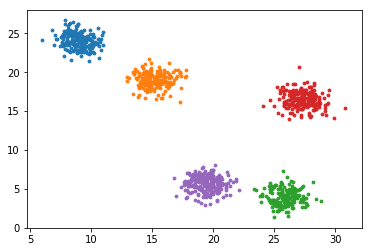

In [64]:
X,X_train,_ = gen_dataset(5,2,1000)
X_train
plotX(X)


[ 1.00483672  1.01973712]
[ 0.98116813  1.04831445]
[ 1.01664884  1.13612979]
[ 0.94430623  0.98091009]
[ 0.98442991  1.01918576]


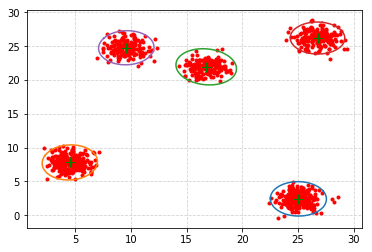

In [49]:
mean,pi,cov = emalgo(5,2,1000,X_train,eps=0.0001,conveps = 0.0000001,iteration=-6,noise_add=0)
giveplot(X_train,mean,cov)

In [44]:
X_new,X_train

(array([[ 0.85740303,  0.51464555],
        [ 0.89798591,  0.44002422],
        [ 0.80367968,  0.59506216],
        ..., 
        [ 0.50380569,  0.86381701],
        [ 0.51458581,  0.85743888],
        [ 0.49632693,  0.86813569]]), array([[ 10.59471328,   6.35934548],
        [ 11.48054356,   5.62560856],
        [ 12.22539975,   9.05195552],
        ..., 
        [ 17.06624599,  29.26150642],
        [ 17.39053984,  28.97733418],
        [ 16.65550131,  29.13248186]]))

In [66]:
X_train1 = X_train/1
X_new = norm_data(X_train1)

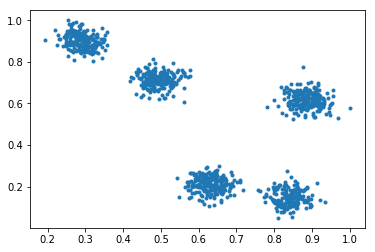

In [67]:
plt.plot(X_new[:,0],X_new[:,1],'.')
plt.show()

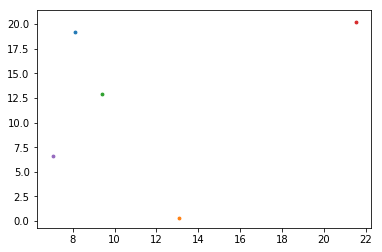

In [101]:
mean_ = list(map(lambda x:x.reshape(1,2),list(mean)))
plotX(mean_)


In [103]:
#a = checking(X_new,len(X_new),2,13,max_lim=100)
nmean,_,ncov= emalgo(5,2,1000,X_train,eps=0.04,epsnoise=0.1,conveps = 0.001,iteration=-5,noise_add=1)


/home/suman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars
/home/suman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/home/suman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in multiply


[ 0.87832091  0.93399104]
[  1.02166112e-07   1.02166112e-07]
[ 0.87292198  0.96069878]
[ 0.91510635  0.9299518 ]
[ 0.2411301   1.02769708]


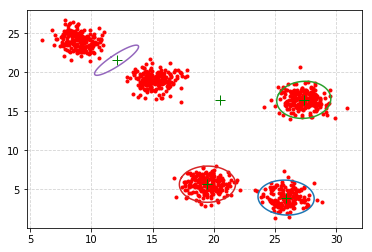

In [106]:
giveplot(X_train,nmean,ncov)

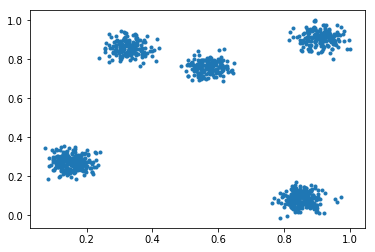

In [111]:
plotX(mean+nmean_)

NameError: name 'nmean_' is not defined

array([  2.31464559e-17,   4.00011840e-01,   1.81999872e-01,
         1.37500343e-19,   4.17988287e-01])

In [112]:
np.random.normal(0, 2, 10)

array([-3.69786923, -3.99148304, -0.26063153,  2.01012582,  0.07491175,
        3.57325503,  1.3373914 ,  4.50475197,  3.09110701,  0.61325922])

In [113]:
cov = 2.5*np.eye(2*(2+1)//2,dtype = float)

In [114]:
np.shape(cov)

(3, 3)

In [115]:
z = np.random.multivariate_normal(np.zeros(2*(2+1)//2), cov)

In [509]:
mean,cov,pi

(array([[ 12.64890353,  14.91533428],
        [ 26.64161003,  19.62704496],
        [ 13.32121629,  16.04032627],
        [  6.85424763,  22.50366076],
        [  1.7375618 ,   0.7214595 ]]),
 [array([[  3.29549679e+85,   2.87642840e+01],
         [  2.87642840e+01,   3.29549679e+85]]),
  array([[ 1.58166869, -0.01862068],
         [-0.01862068,  1.86997516]]),
  array([[ 8.82359948,  4.26025691],
         [ 4.26025691,  3.65901435]]),
  array([[ 1.70370583, -0.14880096],
         [-0.14880096,  1.54034392]]),
  array([[ 1.36601548,  0.04404044],
         [ 0.04404044,  1.6105884 ]])],
 array([  3.03444386e-87,   1.83960296e-01,   4.23039725e-01,
          1.83999980e-01,   2.09000000e-01]))

In [446]:
mean[3]

array([ 0.62002346,  0.4418356 ])

In [408]:
np.dot([10,10],rotation)

array([-13.72661497,   3.40294602])

In [409]:
rotation

array([[-0.85647805, -0.51618345],
       [-0.51618345,  0.85647805]])

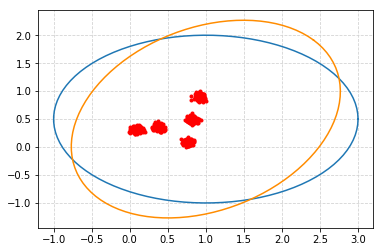

In [421]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi, cos, sin

u=1.       #x-position of the center
v=0.5      #y-position of the center
a=2.       #radius on the x-axis
b=1.5      #radius on the y-axis
t_rot=pi/4 #rotation angle

t = np.linspace(0, 2*pi, 100)
Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
     #u,v removed to keep the same center location
R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
     #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

plt.plot( u+Ell[0,:] , v+Ell[1,:] )     #initial ellipse
plt.plot( u+Ell_rot[0,:] , v+Ell_rot[1,:],'darkorange' )    #rotated ellipse
plt.plot(X_new[:,0],X_new[:,1],'r.')
plt.grid(color='lightgray',linestyle='--')
plt.show()